In [2]:
from os import path as op
import pickle
import pathlib
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
# import rasterstats
from rasterio.features import rasterize
from rasterstats.io import bounds_window
from rasterio.plot import reshape_as_raster, reshape_as_image


from skimage import io
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from treeinterpreter import treeinterpreter as ti

In [3]:
#read path to dataset
#image
img_path = '.\data\Opt_SAR_Stack.tif'
#traing and test dataset
tp_src = gp.read_file('.\data\sgcplot.shp')
tp_crop = gp.read_file('.\data\croplabel.shp')
tp_ncrop = gp.read_file(r'.\data\noncroplabel.shp')
# img_path

In [8]:
crop_label = tp_src.append(tp_crop).append(tp_ncrop)
crop_label = crop_label.to_crs(32736)
crop_label.tail()

,label,geometry
173,0,"POLYGON Z ((648605.608 9905622.155 0.000, 6486..."
174,0,"POLYGON Z ((649982.321 9906989.082 0.000, 6500..."
175,0,"POLYGON Z ((651832.614 9919062.149 0.000, 6518..."
176,0,"POLYGON Z ((651766.644 9918838.993 0.000, 6517..."
177,0,"POLYGON Z ((649204.564 9918381.849 0.000, 6492..."


In [9]:
classes = np.unique(crop_label.label)
classes

array([0, 1], dtype=int64)

In [10]:
class_dict = dict(zip(classes, range(len(classes))))
class_dict

{0: 0, 1: 1}

In [11]:
#Band list
all_band = ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B9", "B11", "B12", "NDVI", "EVI", "GCVI", "RDGCVI", "NDWI", "VH", "VV", "Sarrtio", "Sardiff"]

In [12]:
def all_value(x):
    return x

X_raw = []
y_raw = []

with rasterio.open(img_path, 'r') as src:
    for (label, geom) in zip(crop_label.label, crop_label.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
       # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [31]:
# print(y_raw)

In [13]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((11076, 20), (11076,))

In [14]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.0003059975520195838, 1: 0.000178826895565093}

In [16]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-3,
#     verbose=1,
    random_state=0)

In [17]:
# fit the model to the data (training)
clf.fit(X, y)

RandomForestClassifier(class_weight={0: 0.0003059975520195838,
                                     1: 0.000178826895565093},
                       max_depth=6, n_jobs=-3, random_state=0)

In [18]:
y.shape

(11076,)

In [19]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)
cm #confusion matrix

array([[ 547,  266],
       [  93, 1310]], dtype=int64)

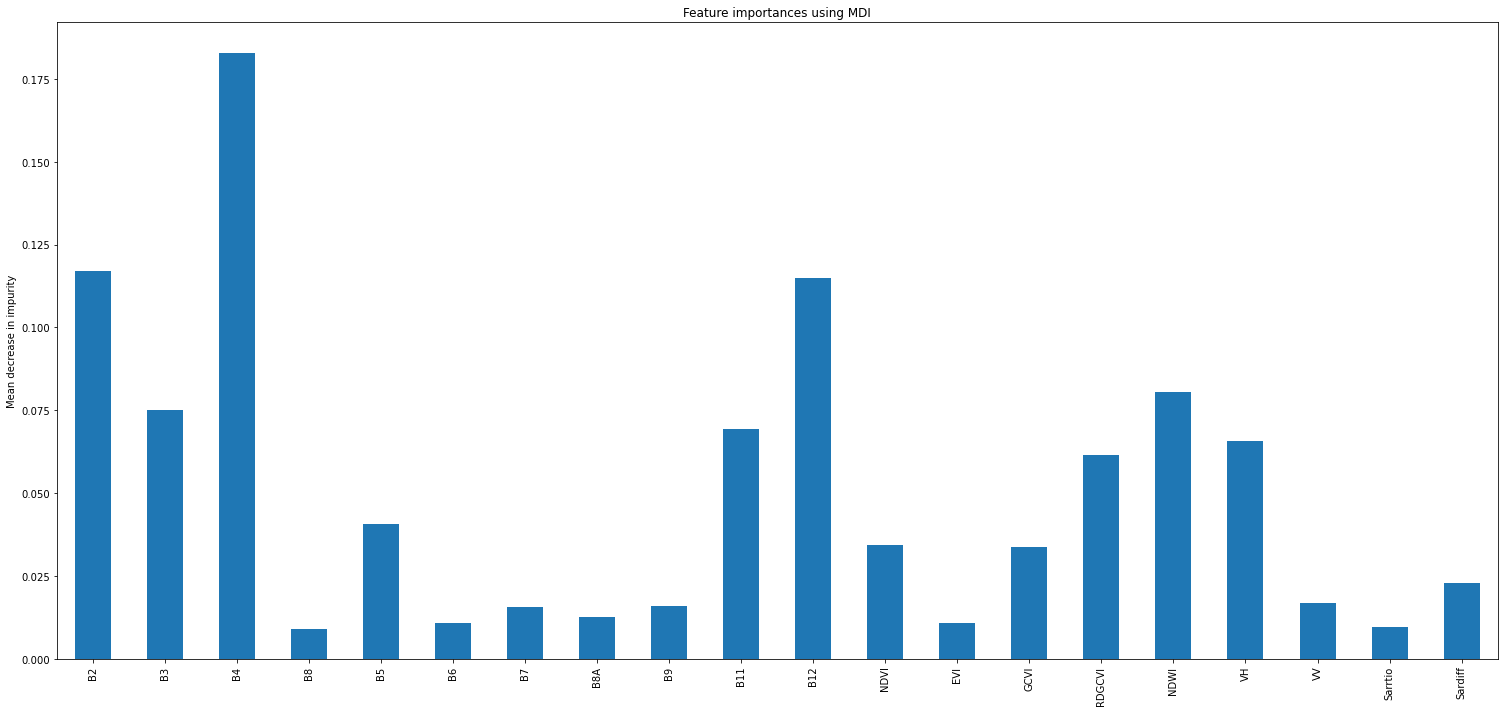

In [20]:
#feature importance
importance = pd.Series(clf.feature_importances_)
x_labels = all_band
fig, ax = plt.subplots()
importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(x_labels)
fig.set_size_inches(21, 10)
fig.tight_layout()

In [55]:
my_dir = r'..\Sugarcane\sci-kit learn\result' #output path

In [59]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = img_path

# specify the output
output_image = op.join(my_dir, "classification.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:
        data = src.read() #this read the image array as (bands, row, columns)
        
        temp = data.transpose(2,1,0)#(rows, cols, layer)
        temp_ = temp.reshape(-1, temp.shape[-1])#2d (all pixel in rows against the features)
        to_predict = np.nan_to_num(temp_, nan=-99999.999)
        
        #predict
        img_preds = clf.predict(to_predict)
        #restore to initial dimension
        output = img_preds.reshape(*temp.shape[:-1])
        #write output
        dst.write(output.astype(rasterio.uint8), 1)
        

In [ ]:
#Numpy understand --

# tp = data.transpose(2,1,0)
# temp = tp.reshape(-1, tp.shape[-1]) #2d
# nonan = np.nan_to_num(temp, nan=0.0)
# nonan.shape
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(temp)
# nwtemp = imp.transform(temp)
# temp1d = temp.reshape(-1)
# temp1d.shape
# tp.shape
# temp.shape
# m = np.ma.masked_invalid(nwtemp)
# tott = nwtemp[~m.mask].reshape(-1, nwtemp.shape[-1])
# tott.shape
# newarr = np.reshape(tott,temp.shape[-1])
# newarr.shape

In [ ]:
# x = np.zeros((3,4,5))
# xx = np.moveaxis(x,0,2).reshape(-1, x.shape[-1])
# xz = xx